In [ ]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
#import
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns=["place_with_parent_names","expenses","floor","operation","property_type","currency","properati_url"], inplace=True)

    df.drop(columns=['price',
                     'price_aprox_local_currency',
                     'price_per_m2',
                     'price_usd_per_m2','surface_total_in_m2','rooms'],inplace=True)

    return df

In [ ]:
files = glob("data/buenos-aires-real-estate-*.csv")
frames = [wrangle(file) for file in files]
#create a dataframe
df = pd.concat(frames,ignore_index=True)
print(df.info())
df.head()

In [ ]:
#Exploring dataset
df.isnull().sum()/len(df)
#check for correlation between features using headmap
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

In [ ]:
#split data
target = "price_aprox_usd"
features=['surface_covered_in_m2','lat','lon','neighborhood']
y_train=df[target]
X_train=df[features]
#baseline model
y_mean=y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))


In [ ]:
#creating a pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),

    Ridge()
)
model.fit(X_train, y_train)

In [ ]:
#model prediction
y_pred_training=model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))
X_test = pd.read_csv("data/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

In [ ]:
def make_prediction(area, lat, lon, neighborhood):
    data={

        "surface_covered_in_m2":area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
    }
    df=pd.DataFrame(data,index=[0])
    prediction =model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

interact(
make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean()
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean()

    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean()
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),

);

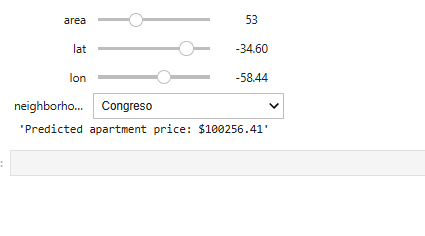

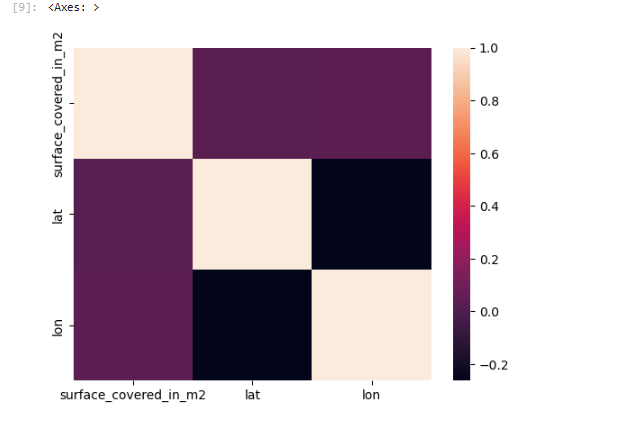